In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../src")
import model.util as model_util
import model.mechint_net as mechint_net
import train.train_model as train_model
import feature.simulated_dataset as simulated_dataset
import analysis.motif_util as motif_util
import analysis.motif_compare as motif_compare
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# Plotting defaults
font_files = font_manager.findSystemFonts(fontpaths="/home/tsenga5/lib/fonts")
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define constants and paths

In [4]:
base_path = "/projects/site/gred/resbioai/tsenga5/mechint_regnet/"

In [5]:
motif_config_path = os.path.join(base_path, "data/simulations/configs/spi1_sanit_single_config.json")
neg_motif_config_path = None

In [6]:
losstune_model_base = os.path.join(base_path, "models/trained_models/simulated/spi1_exp_single/mechint_net_hyper")

In [13]:
figures_out_path = "/home/tsenga5/mechint_regnet/figures/loss_weight_robustness"
os.makedirs(figures_out_path, exist_ok=True)

### Examine performance and interpretability with respect to loss weights

In [7]:
def model_to_pfms(model, data_loader, max_thresh_frac=0.5):
    """
    Given a model and a data loader, runs through the input sequences
    in the data loader and collects convolutional activations from the
    entire epoch.
    Returns a F x W x 4 array of PFMs for the filters. If a filter is
    never activated, its PFM will be all 0.
    """
    _, _, _, _, model_outputs_other, input_data = \
        train_model.run_epoch(data_loader, "eval", model, epoch_num=0, return_extras=True)
    conv_acts = model_outputs_other["conv_acts"]  # Shape: N x L' x F
    input_seqs = input_data[0]  # Shape: N x L x 4
    num_filters = conv_acts.shape[2]
    filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

    # Compute minimum activations needed
    act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

    # Construct PFMs
    pfms = np.zeros((num_filters, filter_width, 4))
    for i in range(num_filters):
        if act_threshes[i] == 0:
            continue
        ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
        if not ex_inds.size:
            # Nothing passed the threshold
            continue
        # Trick to get all matching subsequences, where we flatten the set of all
        # indices we want and then reshape
        seqs = input_seqs[
            np.repeat(ex_inds, filter_width),
            (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
        ].reshape(len(ex_inds), filter_width, -1)
        pfms[i] = np.mean(seqs, axis=0)

    return pfms

In [8]:
data_loader = simulated_dataset.dataset_ex.run(
    "create_data_loader", config_updates={
        "motif_config_path": motif_config_path,
        "input_length": 500,
        "motif_center_dist_bound": 50,
        "batch_size": 128,
        "num_batches": 10,
        "background_match_reject_prob": 1,
        "neg_motif_config_path": neg_motif_config_path
    }
).result

WARNING - root - Added new config entry: "motif_config_path"
WARNING - root - Added new config entry: "neg_motif_config_path"
WARNING - sim_dataset - No observers have been added to this run
INFO - sim_dataset - Running command 'create_data_loader'
INFO - sim_dataset - Started
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO - sim_dataset - Result: <torch.utils.data.dataloader.DataLoader object at 0x153f6b0c2ba0>
INFO - sim_dataset - Completed after 0:00:00


In [9]:
# Import set of true motifs
with open(motif_config_path, "r") as f:
    motif_config = json.load(f)
    motif_files = motif_config["motif_files"]
true_pfms = {}
for motif_file in motif_files:
    true_pfms.update({
        key : val for key, val in motif_util.import_meme_motifs(motif_file).items()
        if key.endswith("_exp")
    })

In [10]:
# For each run, import the loss weights, loss values, performance, and compute interpretability scores
overlap_loss_weights, l1_loss_weights = {}, {}
performance, interpret_scores = {}, {}
overlap_loss_vals, l1_loss_vals = {}, {}
pfms = {}

for run_num in os.listdir(losstune_model_base):
    if not run_num.isnumeric():
        continue
        
    metrics_path = os.path.join(losstune_model_base, run_num, "metrics.json")
    config_path = os.path.join(losstune_model_base, run_num, "config.json")

    with open(metrics_path, "r") as f:
        metrics = json.load(f)
        performance[run_num] = metrics["test_acc"]["values"][0]
        overlap_loss_vals[run_num] = metrics["val_epoch_loss_conv_filter_overlap"]["values"][-1]
        l1_loss_vals[run_num] = metrics["val_epoch_loss_conv_filter_l1"]["values"][-1]
        
    with open(config_path, "r") as f:
        config = json.load(f)
        overlap_loss_weights[run_num] = config["mechint_model"]["conv_filter_over_loss_weight"][-1]
        l1_loss_weights[run_num] = config["mechint_model"]["conv_filter_l1_loss_weight"][-1]

    # Import model and PFMs
    model_path = os.path.join(losstune_model_base, run_num, "last_ckpt.pth")
    model = model_util.load_model(mechint_net.MechIntRegNet, model_path).to(DEVICE)
    pfms[run_num] = model_to_pfms(model, data_loader)

    # Compute interpretability score
    passed_pfms = {i : pfm for i, pfm in enumerate(pfms[run_num]) if np.sum(pfm) > 0}
    tomtom_hits = motif_compare.run_tomtom(
        passed_pfms, true_pfms
    )
    qvals = {i : (np.min(tomtom_hits[i]["q-value"]) if i in tomtom_hits else 1) for i in passed_pfms.keys()}
    interpret_scores[run_num] = np.mean(-np.log10(np.array(list(qvals.values()))))

	Loss: 0.2244: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
	Loss: 0.1877: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.58it/s]
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our sugge

/tmp/ipykernel_3752286/42961811.py:13: RuntimeWarning: divide by zero encountered in log10
  ax[2].scatter(x, np.log10(overlap_loss_vals_arr), color="gray", alpha=0.7)


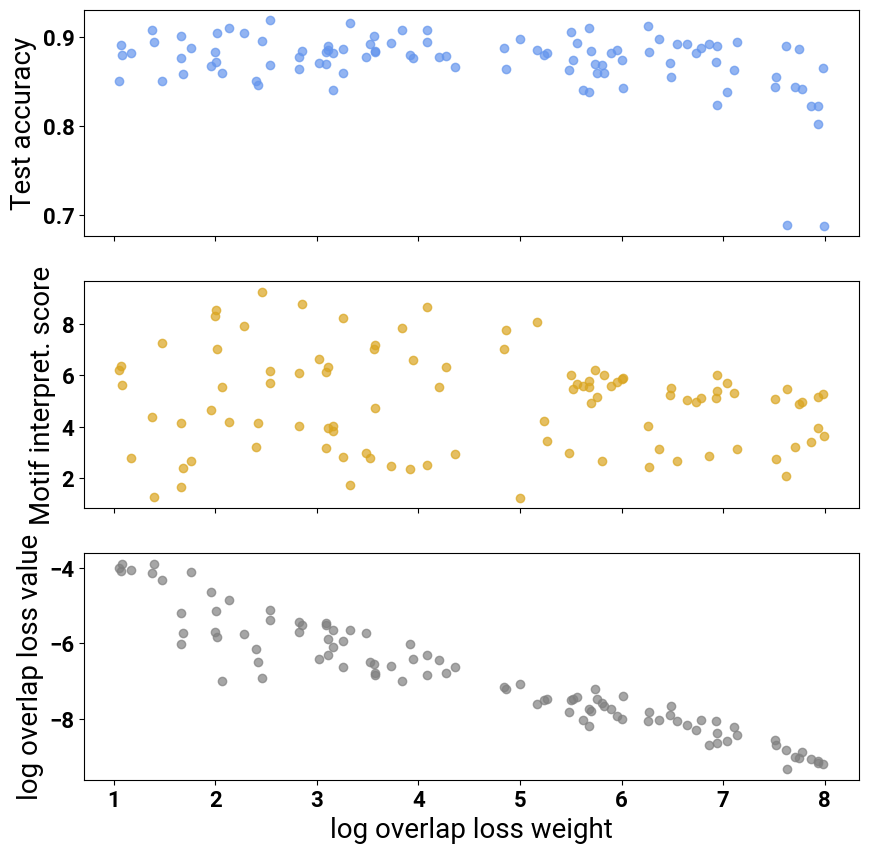

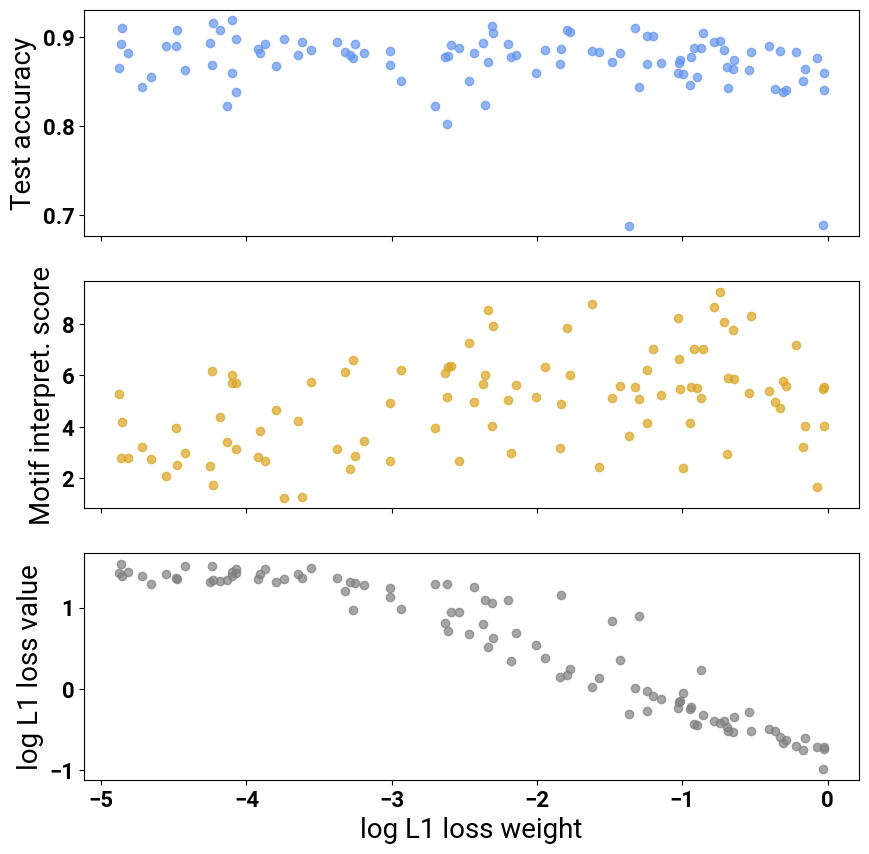

In [14]:
keys = np.array(sorted(list(pfms.keys())))
overlap_loss_weights_arr = np.array([overlap_loss_weights[key] for key in keys])
l1_loss_weights_arr = np.array([l1_loss_weights[key] for key in keys])
performance_arr = np.array([performance[key] for key in keys])
interpret_scores_arr = np.array([interpret_scores[key] for key in keys])
overlap_loss_vals_arr = np.array([overlap_loss_vals[key] for key in keys])
l1_loss_vals_arr = np.array([l1_loss_vals[key] for key in keys])

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))
x = np.log10(overlap_loss_weights_arr)
ax[0].scatter(x, performance_arr, color="cornflowerblue", alpha=0.7)
ax[1].scatter(x, interpret_scores_arr, color="goldenrod", alpha=0.7)
ax[2].scatter(x, np.log10(overlap_loss_vals_arr), color="gray", alpha=0.7)
ax[0].set_ylabel("Test accuracy")
ax[1].set_ylabel("Motif interpret. score")
ax[2].set_ylabel("log overlap loss value")
ax[2].set_xlabel("log overlap loss weight")
plt.show()
fig.savefig(os.path.join(figures_out_path, "overlap_loss_robustness.svg"), format="svg")

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(10, 10))
x = np.log10(l1_loss_weights_arr)
ax[0].scatter(x, performance_arr, color="cornflowerblue", alpha=0.7)
ax[1].scatter(x, interpret_scores_arr, color="goldenrod", alpha=0.7)
ax[2].scatter(x, np.log10(l1_loss_vals_arr), color="gray", alpha=0.7)
ax[0].set_ylabel("Test accuracy")
ax[1].set_ylabel("Motif interpret. score")
ax[2].set_ylabel("log L1 loss value")
ax[2].set_xlabel("log L1 loss weight")
plt.show()
fig.savefig(os.path.join(figures_out_path, "l1_loss_robustness.svg"), format="svg")